In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Dropdown, FloatSlider, HBox, IntSlider, interactive, VBox
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift
from scipy.optimize import minimize
from skimage.draw import disk
from skimage.metrics import mean_squared_error, structural_similarity
from skimage.restoration import denoise_wavelet

In [2]:
def read_rgb_image(subfolder, name):
    image = cv2.imread(f'./images/{subfolder}/{name}.png', cv2.IMREAD_COLOR)
    color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return color_image

In [3]:
def get_comparison_scores(image1, image2):
    # Compute the MSE and SSIM between the images
    mse = mean_squared_error(image1, image2)
    data_range = image2.max() - image2.min()  # Compute the data range
    data_range = 255
    
    # Check the number of dimensions in the image and set the channel_axis parameter
    if len(image1.shape) == 3:
        ssim = structural_similarity(image1, image2, multichannel=True, channel_axis=2, data_range=data_range)
    else:
        ssim = structural_similarity(image1, image2, data_range=data_range)


    return mse, ssim

In [4]:
def plot_images(title, subtitles, *images):
    plt.figure(figsize=(20, 5))  # Increase the size of the figure
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap='gray')

        mse, ssim = get_comparison_scores(images[0], images[i])
        
        # Add the MSE and SSIM to the subtitle
        plt.title(subtitles[i])
        plt.xlabel(f"MSE: {mse:.2f}, SSIM: {ssim:.2f}")
        
        plt.xticks([]), plt.yticks([])
   
    # Add an overall title
    plt.suptitle(title, fontsize=16)
    plt.show()

In [5]:
image_num = "0000"
noise = 50

# Choose from filter options: Gaussian, Butterworth, Disk
filter_type = "butterworth"
radius = 17     # Radius of the circle
order = 1.8       # Butterworth order of the filter

original_image = read_rgb_image("original", image_num)
noisy_image = read_rgb_image(f"noisy{noise}", image_num)

In [6]:
def apply_fourier_transform(image):
    # Apply Fourier Transform to each color channel
    fft_image = [fftshift(fft2(image[:, :, i])) for i in range(3)]

    return fft_image

def visualize_fft(fft_image):
    # Applies a transformation to an FFT image to make it more visually interpretable
    return np.log1p(np.abs(fft_image))

def create_mask(image_shape, mask_type, radius, order):
    # Create a binary mask with a disk (circle) at the center
    rows, cols = image_shape
    mask = np.zeros((rows, cols), dtype=bool)

    # Create a grid of distances from the center of the image
    x = np.arange(-cols//2, cols//2)
    y = np.arange(-rows//2, rows//2)
    x, y = np.meshgrid(x, y)
    radial_distance = np.sqrt(x**2 + y**2)

    if mask_type == "gaussian":
        # Create a Gaussian mask
        mask = np.exp(-radial_distance**2 / (2 * radius**2))
    elif mask_type == "butterworth":
        # Create a Butterworth mask
        mask = 1 / (1 + (radial_distance / radius)**(2*order))
    else:
        # Create a disk (circle) mask
        cx, cy = int(rows/2), int(cols/2)
        rr, cc = disk((cx, cy), radius, shape=image_shape)
        mask[rr, cc] = True

    return mask

def apply_fourier_filter(image, filter_type, radius, order):
    # Apply the filter to each color channel
    filtered_image = [create_mask(channel.shape, filter_type, radius, order) * channel for channel in image]
    
    return filtered_image

def apply_inverse_fourier_transform(filtered_fft_image):
    # Apply inverse Fourier transform and take absolute value for each channel
    final_image_channels = [np.abs(ifft2(ifftshift(channel))) for channel in filtered_fft_image]
    
    # Stack the channels to create a single color image
    final_image = np.dstack(final_image_channels)
    
    # Convert the image back to 8-bit unsigned integer
    final_image = cv2.convertScaleAbs(final_image)
    
    return final_image

In [7]:
def make_denoising_pipeline(noisy_image, filter_type, radius, order):
    # noisy_image = noisy_image = preprocess_image(noisy_image)
    fft_image = apply_fourier_transform(noisy_image)
    fft_filtered_image = apply_fourier_filter(fft_image, filter_type, radius, order)
    
    denoised_image = apply_inverse_fourier_transform(fft_filtered_image)

    return fft_image, fft_filtered_image, denoised_image

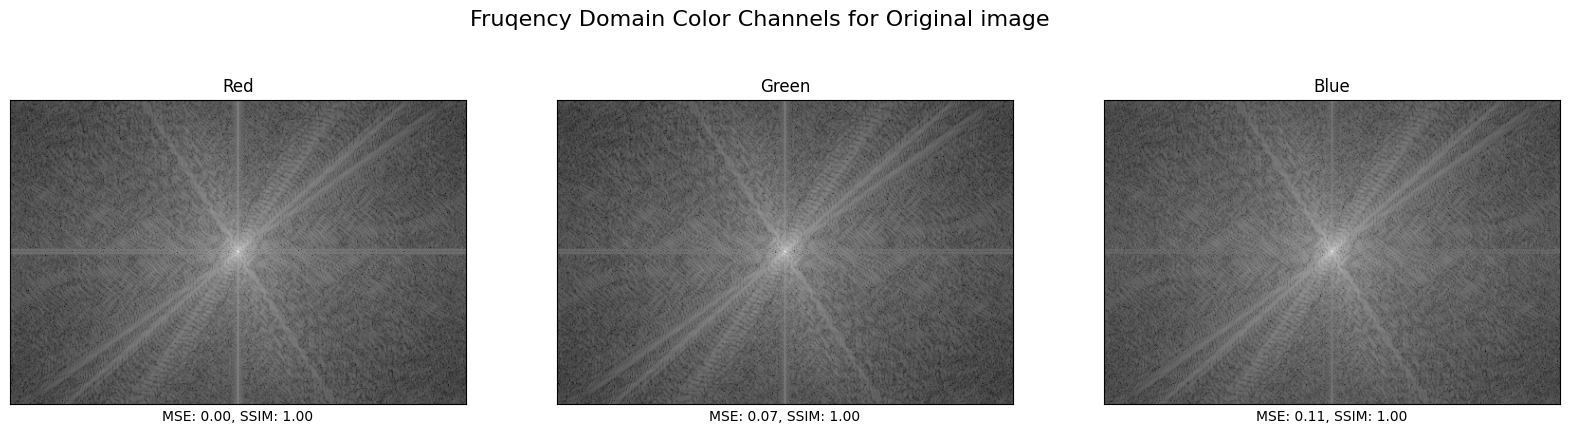

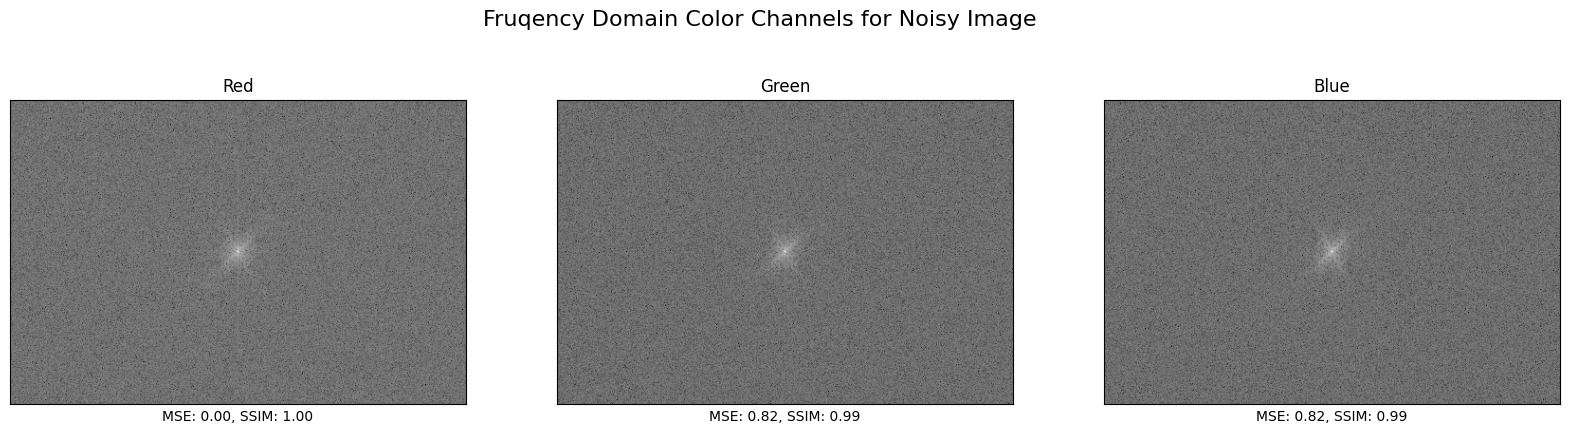

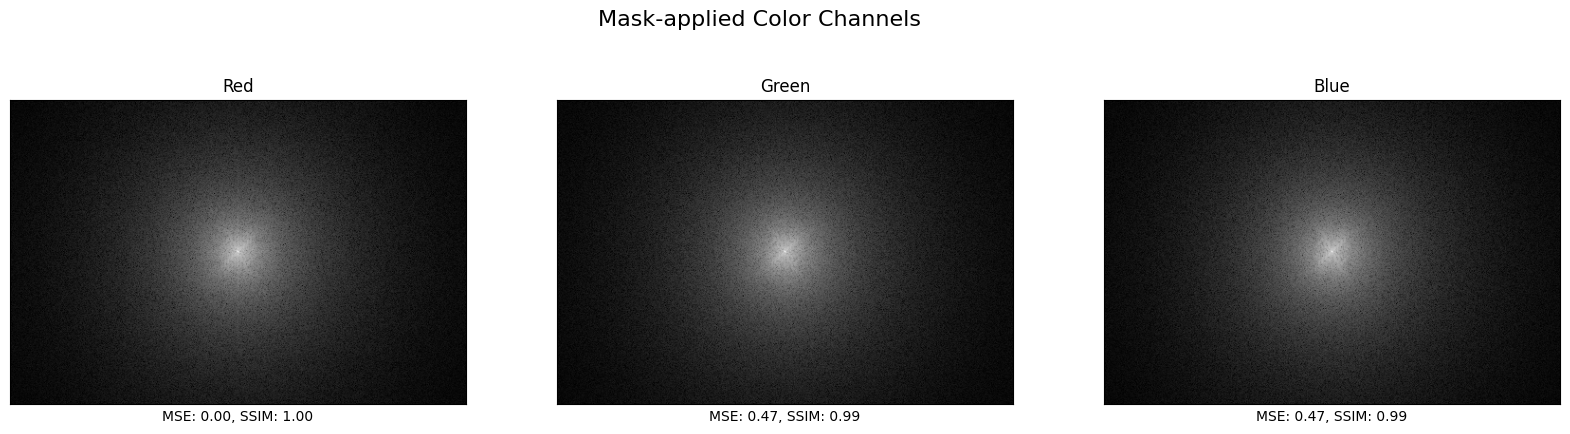

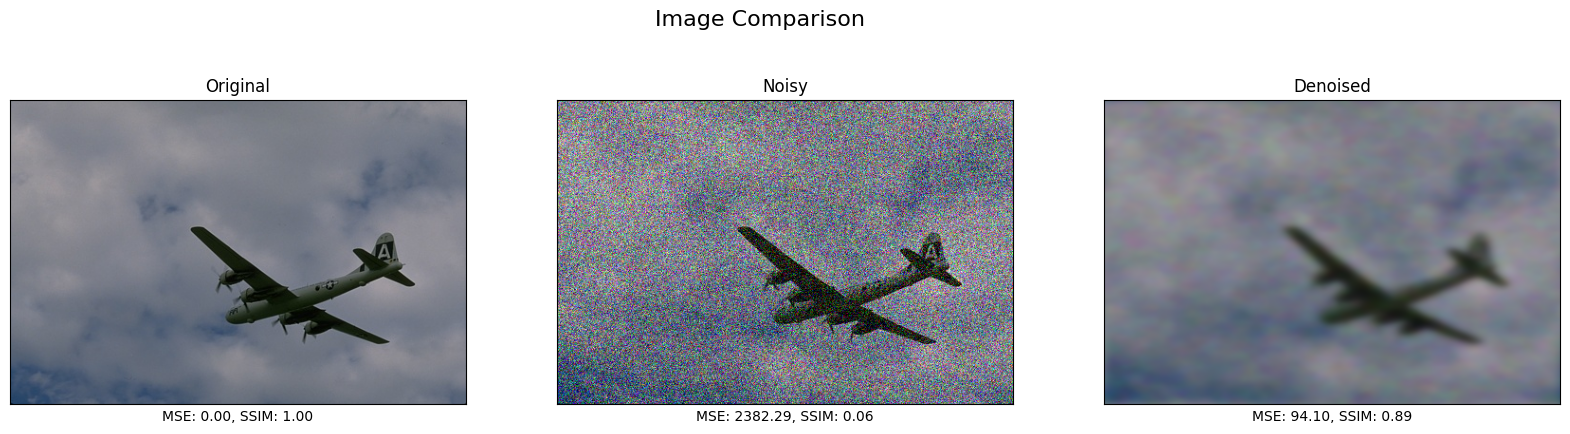

In [8]:
fft, filtered, denoised = make_denoising_pipeline(noisy_image, filter_type, radius, order)

rgb_subtitles = ["Red", "Green", "Blue"]
image_subtitles = ['Original', 'Noisy', 'Denoised']
fft_color_channels = [visualize_fft(fft[i]) for i in range(3)]
fft_filtered_color_channels = [visualize_fft(filtered[i]) for i in range(3)]


og_fft, og_filtered, og_denoised = make_denoising_pipeline(original_image, filter_type, radius, order)
fft_color_channels_for_original = [visualize_fft(og_fft[i]) for i in range(3)]
plot_images("Fruqency Domain Color Channels for Original image", rgb_subtitles, *fft_color_channels_for_original)
plot_images("Fruqency Domain Color Channels for Noisy Image", rgb_subtitles, *fft_color_channels)
plot_images("Mask-applied Color Channels", rgb_subtitles, *fft_filtered_color_channels)
plot_images("Image Comparison", image_subtitles, original_image, noisy_image, denoised)

In [9]:
def interactive_denoising(image_num, noise, filter_type, radius, order):
    original_image = read_rgb_image("original", image_num)
    noisy_image = read_rgb_image(f"noisy{noise}", image_num)
    _, _, denoised = make_denoising_pipeline(noisy_image, filter_type, radius, order)

    plot_images('FFT Denoising', ['Original', 'Noisy', 'Denoised'], original_image, noisy_image, denoised)


# Create the widgets
image_num_widget = Dropdown(options=[f"{i:04d}" for i in range(25)], description='Image')
noise_widget = Dropdown(value='50', options=['10', '25', '50'], description='Noise')
filter_type_widget = Dropdown(value='butterworth', options=['gaussian', 'butterworth', 'disk'], description='Filter')
radius_widget = IntSlider(value=10, min=1, max=100, step=1, description='Radius')
order_widget = FloatSlider(value=1, min=0.5, max=3, step=0.1, description='Order')

# Use the `interactive` function to create interactive widgets for the parameters
out = interactive(
    interactive_denoising, 
    image_num=image_num_widget, 
    noise=noise_widget, 
    filter_type=filter_type_widget, 
    radius=radius_widget, 
    order=order_widget
)

# Create your custom layout
box = VBox([
    HBox([image_num_widget, noise_widget, filter_type_widget]),  
    HBox([radius_widget, order_widget]) 
])

# Display your custom layout
display(box)
display(out.children[-1])

Output()

In [10]:
def apply_filter(noisy_image, filter_type, filter_size=3):
    if filter_type == 'mean':
        # Define the size of the filter
        filter = (filter_size, filter_size)
        # Apply the mean filter to the noisy image
        filtered_image = cv2.blur(noisy_image, filter)
    elif filter_type == 'median':
        # Ensure the filter size is an odd number greater than 1
        if filter_size % 2 == 0:
            filter_size += 1
        if filter_size <= 1:
            filter_size = 3
        # Apply the median filter to the noisy image
        filtered_image = cv2.medianBlur(noisy_image, filter_size)
    elif filter_type == 'wavelet':
       filtered_image = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                           method='BayesShrink', mode='soft')
       filtered_image = (filtered_image * 255).astype(np.uint8)
    return filtered_image

In [11]:
def interactive_filter(image_num, noise, filter_type, filter_size):
    original_image = read_rgb_image("original", image_num)
    noisy_image = read_rgb_image(f"noisy{noise}", image_num)
    filtered_image = apply_filter(noisy_image, filter_type, filter_size)

    plot_images(f"{filter_type.capitalize()} Filter", ['Original', 'Noisy', f'{filter_type.capitalize()} Filter'], original_image, noisy_image, filtered_image)

# Create the widgets
filter_type_widget = Dropdown(value='mean', options=['mean', 'median', 'wavelet'], description='Filter')
filter_size_widget = IntSlider(value=10, min=1, max=50, step=1, description='Filter Size')

# Use the `interactive` function to create interactive widgets for the parameters
out = interactive(
    interactive_filter,
    image_num=image_num_widget, 
    noise=noise_widget, 
    filter_type=filter_type_widget, 
    filter_size=filter_size_widget
)

# Create your custom layout
box = VBox([
    HBox([image_num_widget, noise_widget, filter_type_widget, filter_size_widget]),  
])

# Display your custom layout
display(box)
display(out.children[-1])

Output()

[23.33698559  1.26827888]
Final MSE: 441.6476296569754 | Final SSIm: 0.639591957539516


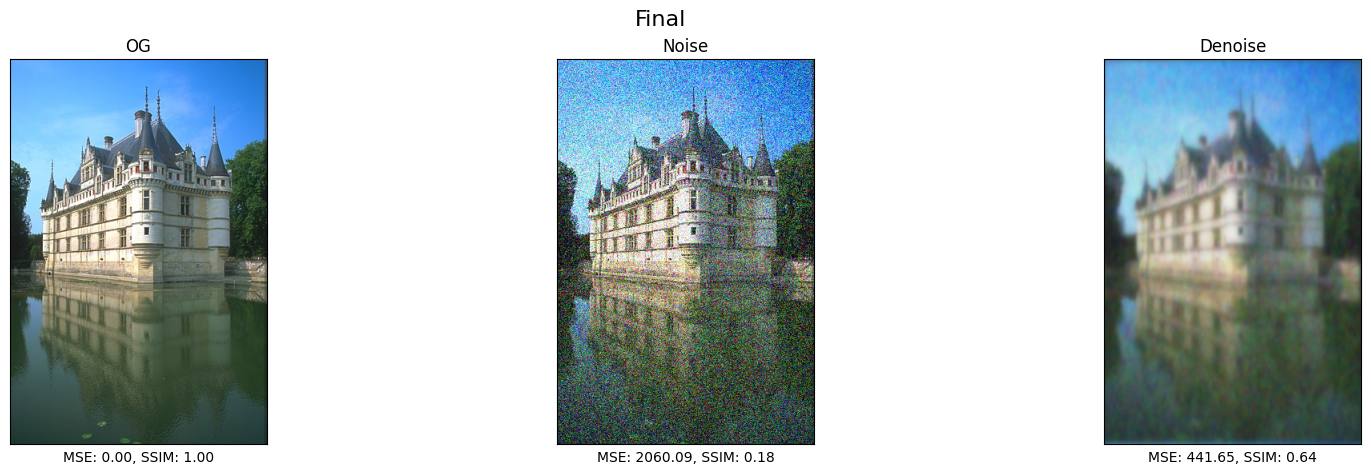

In [52]:
# Read the images
original_image = read_rgb_image("original", "0010")
noisy_image = read_rgb_image(f"noisy50", "0010") 

# Define a new function that calculates SSIM and returns the denoised image
def denoise_and_get_ssim(params):
    radius, order = params
    _, _, denoised = make_denoising_pipeline(noisy_image, "butterworth", radius, order)
    _, ssim = get_comparison_scores(original_image, denoised)
    return denoised, -ssim  # return denoised image and negative SSIM

# Define the objective function to minimize
def objective(params):
    _, neg_ssim = denoise_and_get_ssim(params)
    return neg_ssim

# Initial guess for the parameters
initial_guess = [20, 2]

# Perform the optimization with Nelder-Mead method with early stopping
result = minimize(objective, initial_guess, method='Nelder-Mead', options={'xatol': 0.1, 'fatol': 0.1})

# Calculate and print the final MSE
denoised, neg_ssim = denoise_and_get_ssim(result.x)
final_mse, _ = get_comparison_scores(original_image, denoised)
print(result.x)
print(f"Final MSE: {final_mse} | Final SSIm: {-neg_ssim}")

# Plot the images
plot_images("Final", ["OG", "Noise", "Denoise"], original_image, noisy_image, denoised)